Epoch 1/20, Train Loss: 0.2444, Val Loss: 0.0689
Epoch 2/20, Train Loss: 0.1044, Val Loss: 0.0520
Epoch 3/20, Train Loss: 0.0854, Val Loss: 0.0483
Epoch 4/20, Train Loss: 0.0713, Val Loss: 0.0424
Epoch 5/20, Train Loss: 0.0635, Val Loss: 0.0449
Epoch 6/20, Train Loss: 0.0552, Val Loss: 0.0469
Epoch 7/20, Train Loss: 0.0508, Val Loss: 0.0382
Epoch 8/20, Train Loss: 0.0466, Val Loss: 0.0383
Epoch 9/20, Train Loss: 0.0436, Val Loss: 0.0370
Epoch 10/20, Train Loss: 0.0393, Val Loss: 0.0331
Epoch 11/20, Train Loss: 0.0377, Val Loss: 0.0339
Epoch 12/20, Train Loss: 0.0325, Val Loss: 0.0356
Epoch 13/20, Train Loss: 0.0312, Val Loss: 0.0346
Epoch 14/20, Train Loss: 0.0286, Val Loss: 0.0328
Epoch 15/20, Train Loss: 0.0296, Val Loss: 0.0288
Epoch 16/20, Train Loss: 0.0255, Val Loss: 0.0320
Epoch 17/20, Train Loss: 0.0258, Val Loss: 0.0346
Epoch 18/20, Train Loss: 0.0232, Val Loss: 0.0331
Epoch 19/20, Train Loss: 0.0230, Val Loss: 0.0286
Epoch 20/20, Train Loss: 0.0224, Val Loss: 0.0276
Epoch 1/2

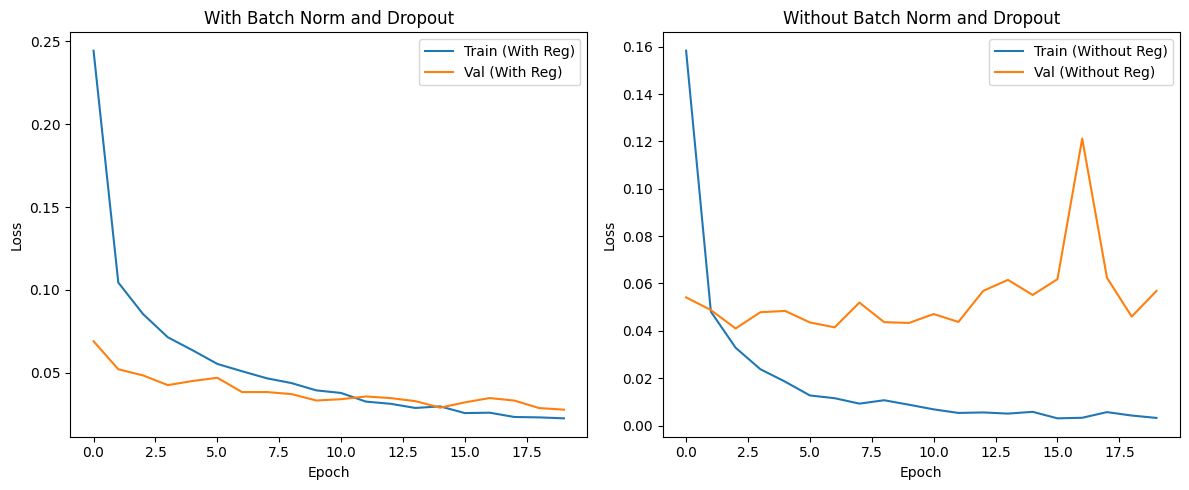

Test Accuracy (With Regularization): 99.18%
Test Accuracy (Without Regularization): 99.02%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Setting the random seed
torch.manual_seed(42)

# loading and preprocessing the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Loading the MNIST dataset
mnist_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Splitting the dataset into training and validation sets
train_size = int(0.8 * len(mnist_dataset))
val_size = len(mnist_dataset) - train_size
train_dataset, val_dataset = random_split(mnist_dataset, [train_size, val_size])

# Creating data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Loading the test dataset
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Model with Batch Normalization and Dropout
class CNNWithRegularization(nn.Module):
    def __init__(self):
        super(CNNWithRegularization, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 7 * 7)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Model without Batch Normalization and Dropout
class CNNWithoutRegularization(nn.Module):
    def __init__(self):
        super(CNNWithoutRegularization, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Training function
def train(model, train_loader, val_loader, criterion, optimizer, epochs):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return train_losses, val_losses

# Create and train both models
model_with_reg = CNNWithRegularization()
model_without_reg = CNNWithoutRegularization()

criterion = nn.CrossEntropyLoss()
optimizer_with_reg = optim.Adam(model_with_reg.parameters(), lr=0.001, weight_decay=1e-4)
optimizer_without_reg = optim.Adam(model_without_reg.parameters(), lr=0.001)

epochs = 20

train_losses_with_reg, val_losses_with_reg = train(model_with_reg, train_loader, val_loader, criterion, optimizer_with_reg, epochs)
train_losses_without_reg, val_losses_without_reg = train(model_without_reg, train_loader, val_loader, criterion, optimizer_without_reg, epochs)

# Plotting the results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_with_reg, label='Train (With Reg)')
plt.plot(val_losses_with_reg, label='Val (With Reg)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('With Batch Norm and Dropout')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses_without_reg, label='Train (Without Reg)')
plt.plot(val_losses_without_reg, label='Val (Without Reg)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Without Batch Norm and Dropout')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluating both models on the test set
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

accuracy_with_reg = evaluate(model_with_reg, test_loader)
accuracy_without_reg = evaluate(model_without_reg, test_loader)

print(f"Test Accuracy (With Regularization): {accuracy_with_reg:.2f}%")
print(f"Test Accuracy (Without Regularization): {accuracy_without_reg:.2f}%")

**The Use of Batch Normalization and Dropout Layer in a Neural Network**

**Batch Normalization Layer** - This is a technique used to normalize the inputs in each layer in a neural network by shifting and scaling the activations. It subtracts the batch mean and then divides it by the batch standard deviation. This solves the problem of the so-called Internal Covariate thift. The advantages of using batch normalization include faster training, higher learning rates, less sensitivity to initialization, and some regularization effects. It is particularly useful in deep networks where it helps greatly with the stability of training and convergence.
**Dropout Layer** - This is a regularization technique used to avoid overfitting in neural networks. During training time, dropout randomly sets a fraction of the input units to 0 during each update, preventing complexity of the training data.  Dropout helps generalize better and avoid overfitting, especially when the model has many layers or is prone to overfitting.

**Effects of the Two on the Model**

1. Stability. The model with regularization shows smoother and more consistent loss reduction both for training and validation.
2. Generalization. Smaller gap between training and validation loss demonstrate better generalization.
3. Overfitting prevention. Validation loss continues to decrease, unlike the unregularized model where it fluctuates and increases.
4. Overall performance. Slightly higher test accuracy (99.18% vs 99.02%), demonstrating marginally better generalization to unseen data.
